<center>

**EE6347 : Devices and Technologies for AI and Neuromorphic Computing**

**Assignment 1 : Single Neuron Logistic Regression**

Name : ANIRUDH B S ; Roll No. : EE21B019
</center>

**Question 1**

You have a training dataset with 60,000 images. How many samples per iteration (of gradient descent) you can have if you employ “mini-batch” gradient descent?

Answer : (d) 1 < samples < 60,000

## **Neural Network Implementation** ###

## 1.1 Importing the library and dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Problem Statement: You are given a dataset ("data.h5") containing:

- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).
You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat

Let's get more familiar with the dataset. Load the data by running the following code

In [ ]:
import sys
path='/content/gdrive/MyDrive/EE6347_Assignment1/'
sys.path.append(path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import copy
from PIL import Image
from scipy import ndimage


In [ ]:
def load_data():

    with h5py.File('/content/gdrive/MyDrive/EE6347_Assignment1/train_catvnoncat.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File('/content/gdrive/MyDrive/EE6347_Assignment1/test_catvnoncat.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes= load_data()



Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code.


y = 0


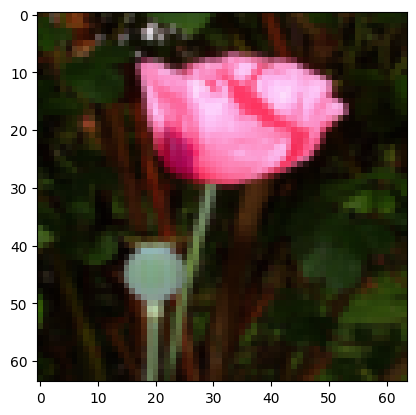

In [ ]:
index = 30
plt.imshow(train_set_x_orig[index])
print (f"y = {train_set_y[0,index]}")

**Exercise: Find the values for:**

- m_train (number of training examples)
- m_test (number of test examples)
- num_px (= height = width of a training image)

Remember that train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access m_train by writing train_set_x_orig.shape[0].

In [ ]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print(f"Number of training examples are {m_train}")
print(f"Number of test examples are {m_test}")
print(f"Number of pixels are {num_px}")

Number of training examples are 209
Number of test examples are 50
Number of pixels are 64




**Exercise:**
Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened.

In [ ]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.


Let's normalize our dataset

In [ ]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

## PART_B ######

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a simple neural network with one neuron.


Key steps: In this exercise, you will carry out the following steps:

- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

## Building the parts of our algorithm

The main steps for building a Neural Network are:

Define the model structure (such as number of input features)

Initialize the model's parameters

Loop:

Calculate current loss (forward propagation)

Calculate current gradient (backward propagation)

Update the parameters (gradient descent)


## HELPER FUNCTIONS ####

### B.1  Exercise: Implement Sigmoid Function: sigmoid()

𝑎= 𝜎(𝑧)=  1/(1 + 𝑒xp(−𝑧) )

In [ ]:
def sigmoid(z):
  return 1/(1+np.exp(-z))


In [ ]:
inp = [3, -25, -0.7, 25]
oup = sigmoid(np.array(inp))
print(oup)

[9.52574127e-01 1.38879439e-11 3.31812228e-01 1.00000000e+00]


### B.2 Initializing Parameter

i.e. w and b

for network with single neuron we will initialize with random weights and zero bias.

In [ ]:
def initialize_with_zeros(dim):
  w = np.random.rand(dim, 1)
  b = np.random.rand()

  return w, b

In [ ]:
initialize_with_zeros(4)

(array([[0.57684617],
        [0.54527914],
        [0.16270866],
        [0.91503631]]),
 0.7551941013598177)

### B.3 Forward and Backward Propogation
you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagation()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X of dimension (n, m) n=no of input feture, m=no of training example
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [ ]:
def propagation(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -1/m * (np.sum(Y* np.log(A) + (1-Y)*np.log(1-A)))

    dw = 1/m * (np.dot(X, (A-Y).T))
    db = 1/m * (np.sum(A-Y))

    cost = np.squeeze(np.array(cost))
    grads = {'dw' : dw, 'db' : db}

    return grads, cost

### B.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [ ]:
def optimization(w, b, X, Y, num_itertions = 1000, learning_rate = 0.001, print_cost = False):
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(num_itertions):
      grads, cost = propagation(w, b, X, Y)
      dw = grads['dw']
      db = grads['db']
      w = w - learning_rate * dw
      b = b - learning_rate * db

      if i%100==0:
        costs.append(cost)

        if print_cost:
          print(f"Cost after iteration {i} is {cost}")

      params = {'w' : w, 'b' : b}
      grads = {'dw' : dw, 'db' : db}

    return params, grads, costs

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`.

In [ ]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros(shape = (1, m), dtype = np.float128)
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(m):
      if A[0, i] > 0.5:
        Y_prediction[0,i] = 1
      else :
        Y_prediction[0,i] = 0

    return Y_prediction

In [ ]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


## C - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction_test for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimization()

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 200000, learning_rate = 0.5, print_cost = False):

    w, b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimization(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = False)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [ ]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

<ipython-input-20-f8fac2858c83>:4: RuntimeWarning: divide by zero encountered in log
  cost = -1/m * (np.sum(Y* np.log(A) + (1-Y)*np.log(1-A)))
<ipython-input-20-f8fac2858c83>:4: RuntimeWarning: invalid value encountered in multiply
  cost = -1/m * (np.sum(Y* np.log(A) + (1-Y)*np.log(1-A)))


train accuracy: 91.38755980861244 %
test accuracy: 76.0 %
